In [ ]:
# !pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python mediapipe sklearn matplotlib tqdm flask

In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp
from tqdm import tqdm
import tensorflow as tf

2022-05-02 16:59:37.129103: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/aayush/Thesis/Thesis2022/my_project/venv/lib/python3.8/site-packages/cv2/../../lib64:
2022-05-02 16:59:37.129159: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

def draw_landmarks(image, results):
    #mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACE_CONNECTIONS) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

def draw_styled_landmarks(image, results):
    # Draw face connections
    #mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACE_CONNECTIONS, 
    #                         mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
    #                         mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
    #                         ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(0,246,205), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(7,0,219), thickness=1, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             )     



In [66]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.9, min_tracking_confidence=0.9) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        #print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)

        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

In [4]:
cap.release()
cv2.destroyAllWindows()

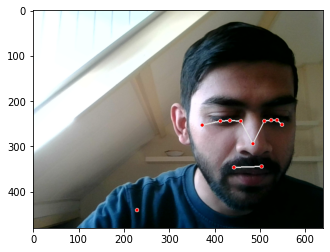

In [4]:
draw_landmarks(frame, results)
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

In [3]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh]), lh, rh

In [8]:
DATA_PATH = os.path.join('SLR_T_DATA')

actions = np.array(['Positive', 'Negative', 'Neutral']) ### for SLR_T_DATA folder

In [4]:
# stores number of videos for each action.
no_sequences = 60 #5 #

# stores number of frames per video
sequence_length = 50

start_folder = 1 

In [34]:
for action in actions: 
    if os.path.exists(os.path.join(DATA_PATH, action)):
        dirmax = np.max(np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int))
    else:
        dirmax = 0
    
    for sequence in range(1,no_sequences+1):
        try:
            os.makedirs(os.path.join(DATA_PATH, action, str(dirmax+sequence)))
        except:
            pass

In [38]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    # NEW LOOP
    # Loop through actions
    for action in actions:
        # Loop through sequences aka videos
        for sequence in range(start_folder, start_folder+no_sequences):
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):

                # Read feed
                ret, frame = cap.read()

                # Make detections
                image, results = mediapipe_detection(frame, holistic)

                # Draw landmarks
                draw_styled_landmarks(image, results)
                
                # NEW Apply wait logic
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(500)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    
                
                # NEW Export keypoints
                keypoints, lh,rh = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)
                                
                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
            cv2.waitKey(1000)
                    
    cap.release()
    cv2.destroyAllWindows()

In [30]:
cap.release()
cv2.destroyAllWindows()

In [5]:
start_folder

1

In [6]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical


In [9]:
actions = np.array(['Yes', 'No', 'Maybe', 'Positive', 'Negative', 'Neutral']) ### for SLR_T_DATA folder
label_map = {label:num for num, label in enumerate(actions)}
label_map

sequences, labels = [], []
for action in actions:
    for sequence in range(start_folder, start_folder + no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)),allow_pickle=True)
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])
        
X = np.array(sequences)
X.shape

Y = to_categorical(labels).astype(int)
Y.shape

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5)



In [10]:
X_test.shape

(180, 50, 1662)

In [11]:
label_map

{'Yes': 0, 'No': 1, 'Maybe': 2, 'Positive': 3, 'Negative': 4, 'Neutral': 5}

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, GRU
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from statistics import mode

In [13]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)
es_callback = EarlyStopping(monitor='loss', patience=10)

model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(None,1662)))
model.add(LSTM(128, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

2022-05-02 17:00:42.036645: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2022-05-02 17:00:42.036674: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2022-05-02 17:00:42.045975: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-05-02 17:00:43.375550: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2022-05-02 17:00:43.407102: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-05-02 17:00:44.782711: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-05-02 17:00:44.782741: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (aayush-Ubuntu): /proc/driver/nvidia/version does not exist
2022-05-02 17:00:44.

In [12]:
actions.shape[0]

6

In [14]:
#model.build(input_shape=(None,None,1662))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 64)          442112    
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               98816     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 198       
Total params: 551,462
Trainable params: 551,462
Non-trainable params: 0
_________________________________________________________________


In [133]:
model.fit(X_train, Y_train, epochs=1000, callbacks=[tb_callback])

Epoch 1/1000
 2/11 [====>.........................] - ETA: 1s - loss: 3.5975 - categorical_accuracy: 0.3047 

2022-04-29 01:09:58.406868: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2022-04-29 01:09:58.406892: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.


 4/11 [=========>....................] - ETA: 1s - loss: 17.5686 - categorical_accuracy: 0.2721

2022-04-29 01:09:58.588726: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2022-04-29 01:09:58.628076: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2022-04-29 01:09:58.685935: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: Logs/train/plugins/profile/2022_04_29_01_09_58
2022-04-29 01:09:58.731530: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to Logs/train/plugins/profile/2022_04_29_01_09_58/aayush-Ubuntu.trace.json.gz
2022-04-29 01:09:58.754011: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: Logs/train/plugins/profile/2022_04_29_01_09_58
2022-04-29 01:09:58.754105: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for memory_profile.json.gz to Logs/train/plugins/profile/2022_04_29_01_09_58/aayush-Ubuntu.memory_profile.json.gz
2022-04-29 01:09:58.754784: I

11/11 [==============================] - 2s 107ms/step - loss: 29.2340 - categorical_accuracy: 0.2208
Epoch 2/1000
11/11 [==============================] - 1s 82ms/step - loss: 84.1712 - categorical_accuracy: 0.1350
Epoch 3/1000
11/11 [==============================] - 1s 78ms/step - loss: 297.6148 - categorical_accuracy: 0.1982
Epoch 4/1000
11/11 [==============================] - 1s 76ms/step - loss: 136.1474 - categorical_accuracy: 0.1313
Epoch 5/1000
11/11 [==============================] - 1s 83ms/step - loss: 104.7664 - categorical_accuracy: 0.1191
Epoch 6/1000
11/11 [==============================] - 1s 80ms/step - loss: 131.4024 - categorical_accuracy: 0.2005
Epoch 7/1000
11/11 [==============================] - 1s 84ms/step - loss: 60.7843 - categorical_accuracy: 0.1382
Epoch 8/1000
11/11 [==============================] - 1s 78ms/step - loss: 32.1952 - categorical_accuracy: 0.1827
Epoch 9/1000
11/11 [==============================] - 1s 88ms/step - loss: 6.1315 - categorical_

11/11 [==============================] - 1s 92ms/step - loss: 1.7926 - categorical_accuracy: 0.1699
Epoch 144/1000
11/11 [==============================] - 1s 91ms/step - loss: 1.7918 - categorical_accuracy: 0.1816
Epoch 145/1000
11/11 [==============================] - 1s 79ms/step - loss: 1.7921 - categorical_accuracy: 0.1808
Epoch 146/1000
11/11 [==============================] - 1s 81ms/step - loss: 1.7912 - categorical_accuracy: 0.1521
Epoch 147/1000
11/11 [==============================] - 1s 82ms/step - loss: 1.7912 - categorical_accuracy: 0.1670
Epoch 148/1000
11/11 [==============================] - 1s 86ms/step - loss: 1.7914 - categorical_accuracy: 0.1774
Epoch 149/1000
11/11 [==============================] - 1s 85ms/step - loss: 1.7920 - categorical_accuracy: 0.1762
Epoch 150/1000
11/11 [==============================] - 1s 85ms/step - loss: 1.7907 - categorical_accuracy: 0.1702
Epoch 151/1000
11/11 [==============================] - 1s 84ms/step - loss: 1.7916 - categoric

11/11 [==============================] - 1s 73ms/step - loss: 1.7915 - categorical_accuracy: 0.1663
Epoch 286/1000
11/11 [==============================] - 1s 75ms/step - loss: 1.7906 - categorical_accuracy: 0.1662
Epoch 287/1000
11/11 [==============================] - 1s 79ms/step - loss: 1.7912 - categorical_accuracy: 0.1785
Epoch 288/1000
11/11 [==============================] - 1s 75ms/step - loss: 1.7910 - categorical_accuracy: 0.1800
Epoch 289/1000
11/11 [==============================] - 1s 81ms/step - loss: 1.7911 - categorical_accuracy: 0.1908
Epoch 290/1000
11/11 [==============================] - 1s 81ms/step - loss: 1.7909 - categorical_accuracy: 0.1883
Epoch 291/1000
11/11 [==============================] - 1s 81ms/step - loss: 1.7906 - categorical_accuracy: 0.1731
Epoch 292/1000
11/11 [==============================] - 1s 79ms/step - loss: 1.7919 - categorical_accuracy: 0.1853
Epoch 293/1000
11/11 [==============================] - 1s 74ms/step - loss: 1.7927 - categoric

11/11 [==============================] - 1s 79ms/step - loss: 1.7904 - categorical_accuracy: 0.1679
Epoch 428/1000
11/11 [==============================] - 1s 77ms/step - loss: 1.7921 - categorical_accuracy: 0.1777
Epoch 429/1000
11/11 [==============================] - 1s 76ms/step - loss: 1.7909 - categorical_accuracy: 0.1786
Epoch 430/1000
11/11 [==============================] - 1s 79ms/step - loss: 1.7897 - categorical_accuracy: 0.1874
Epoch 431/1000
11/11 [==============================] - 1s 74ms/step - loss: 1.7899 - categorical_accuracy: 0.1949
Epoch 432/1000
11/11 [==============================] - 1s 79ms/step - loss: 1.7911 - categorical_accuracy: 0.1675
Epoch 433/1000
11/11 [==============================] - 1s 78ms/step - loss: 1.7898 - categorical_accuracy: 0.1727
Epoch 434/1000
11/11 [==============================] - 1s 81ms/step - loss: 1.7917 - categorical_accuracy: 0.1719
Epoch 435/1000
11/11 [==============================] - 1s 80ms/step - loss: 1.7922 - categoric

KeyboardInterrupt: 

In [44]:
model.save('slr_6action_2lstm_Adam_acc.100_v5.h5')

In [135]:
del model

In [15]:
model.load_weights('slr_6action_2lstm_Adam_acc.100_v5.h5')

In [16]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

yhat = model.predict(X_test)

ytrue = np.argmax(Y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

multilabel_confusion_matrix(ytrue, yhat)
accuracy_score(ytrue, yhat) * 100

2022-05-02 17:01:49.573546: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 59832000 exceeds 10% of free system memory.
2022-05-02 17:01:49.625782: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-05-02 17:01:49.655429: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2599990000 Hz


100.0

In [22]:
sequence = []
sentence = []
predictions = []
threshold = 0.90

cap = cv2.VideoCapture(0)

with mp_holistic.Holistic(min_detection_confidence=0.7, min_tracking_confidence=0.7) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints,lh, rh = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-50:]
        
        if len(sequence) == 50 and (sum(lh) != 0  or sum(rh) != 0):
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            print("Accuracy:", res[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            
        
            if np.unique(predictions[-5:])[0] == np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    print("Accuracy:", res[np.argmax(res)])
                    #sequence = []
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), cv2.FONT_HERSHEY_SIMPLEX, 1,
                    (255, 255, 255), 2, cv2.LINE_AA)
        
        cv2.imshow('OpenCV Feed', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

Yes
Accuracy: 0.9880639
Accuracy: 0.9880639
Yes
Accuracy: 0.9054687
Accuracy: 0.9054687
Yes
Accuracy: 0.97046083
Accuracy: 0.97046083
Yes
Accuracy: 0.975871
Accuracy: 0.975871
Yes
Accuracy: 0.9702547
Accuracy: 0.9702547
Yes
Accuracy: 0.9630943
Accuracy: 0.9630943
Yes
Accuracy: 0.9713641
Accuracy: 0.9713641
Yes
Accuracy: 0.95229375
Accuracy: 0.95229375
Yes
Accuracy: 0.75216305
Yes
Accuracy: 0.6067451
No
Accuracy: 0.56396914
No
Accuracy: 0.973679
No
Accuracy: 0.8936579
No
Accuracy: 0.593677
No
Accuracy: 0.8563158
Maybe
Accuracy: 0.5997098
Maybe
Accuracy: 0.63981014
Maybe
Accuracy: 0.69012195
Maybe
Accuracy: 0.74660736
Maybe
Accuracy: 0.7666053
Maybe
Accuracy: 0.7773725
Maybe
Accuracy: 0.7838258
Maybe
Accuracy: 0.7723356
Maybe
Accuracy: 0.7436132
Maybe
Accuracy: 0.68836963
Maybe
Accuracy: 0.6044947
Maybe
Accuracy: 0.48652005
No
Accuracy: 0.537142
No
Accuracy: 0.6801718
No
Accuracy: 0.7779451
No
Accuracy: 0.8560551
No
Accuracy: 0.9024197
Accuracy: 0.9024197
No
Accuracy: 0.9387583
Accuracy:

Maybe
Accuracy: 0.9992231
Accuracy: 0.9992231
Maybe
Accuracy: 0.9990853
Accuracy: 0.9990853
Maybe
Accuracy: 0.99896026
Accuracy: 0.99896026
Maybe
Accuracy: 0.9997496
Accuracy: 0.9997496
No
Accuracy: 0.658343
No
Accuracy: 0.9902534
Accuracy: 0.9902534
Yes
Accuracy: 0.85483336
Positive
Accuracy: 0.5050052
Neutral
Accuracy: 0.9289758
Neutral
Accuracy: 0.9951141
Neutral
Accuracy: 0.9985709
Neutral
Accuracy: 0.99928916
Neutral
Accuracy: 0.9994287
Accuracy: 0.9994287
Neutral
Accuracy: 0.9991504
Accuracy: 0.9991504
Neutral
Accuracy: 0.99937063
Accuracy: 0.99937063
Neutral
Accuracy: 0.9914261
Accuracy: 0.9914261
Neutral
Accuracy: 0.94576496
Accuracy: 0.94576496
Neutral
Accuracy: 0.8708992
Neutral
Accuracy: 0.6419689
Maybe
Accuracy: 0.716089
Maybe
Accuracy: 0.938822
Accuracy: 0.938822
Maybe
Accuracy: 0.9870164
Accuracy: 0.9870164
Maybe
Accuracy: 0.9967926
Accuracy: 0.9967926
Maybe
Accuracy: 0.9986154
Accuracy: 0.9986154
Maybe
Accuracy: 0.99985933
Accuracy: 0.99985933
Maybe
Accuracy: 0.97739947


In [34]:
cap.release()
cv2.destroyAllWindows()

In [60]:
predictions[-5:]

[0, 0, 0, 0, 0]